In [1]:
import torch
import MiniFL as mfl

In [2]:
NUM_CLIENTS = 20

In [3]:
def get_task():
    return mfl.tasks.get_svm_regression_fns(
        data_path="phishing.txt",
        num_clients=NUM_CLIENTS,
        batch_size=-1,
    )

In [4]:
GD_STEPS = 100

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_gd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma=0.1,
)

GD_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, GD_STEPS)

100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


In [5]:
EF21_EDEN_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_ef21_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.EdenContractiveCompressor(master_fn.size(), bits=1.5) for _ in range(NUM_CLIENTS)],
    gamma=0.1,
)

EF21_EDEN_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, EF21_EDEN_STEPS)

100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


In [6]:
EF21_TOP_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_ef21_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.TopKCompressor(master_fn.size(), p=1.5*1/32) for _ in range(NUM_CLIENTS)],
    gamma=0.1,
)

EF21_TOP_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, EF21_TOP_STEPS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


In [7]:
EF21_RAND_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_ef21_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.RandKContractiveCompressor(master_fn.size(), p=1.5*1/32) for _ in range(NUM_CLIENTS)],
    gamma=0.1,
)

EF21_RAND_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, EF21_RAND_STEPS)

100%|██████████| 1000/1000 [01:01<00:00, 16.28it/s]


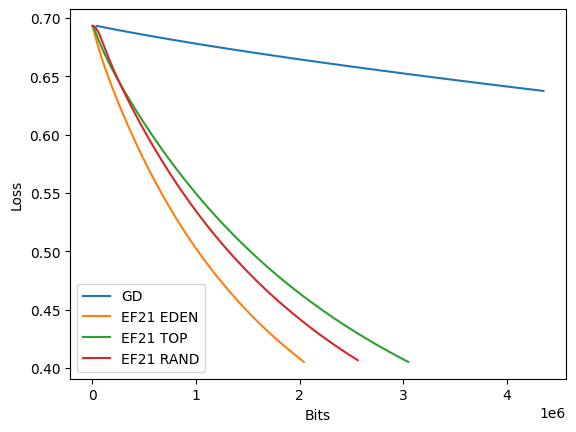

In [8]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.value for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in EF21_EDEN_METRICS], [metrics.value for metrics in EF21_EDEN_METRICS], label="EF21 EDEN")
plt.plot([metrics.total_bits_received for metrics in EF21_TOP_METRICS], [metrics.value for metrics in EF21_TOP_METRICS], label="EF21 TOP")
plt.plot([metrics.total_bits_received for metrics in EF21_RAND_METRICS], [metrics.value for metrics in EF21_RAND_METRICS], label="EF21 RAND")

plt.xlabel("Bits")
plt.ylabel("Loss")
plt.legend()

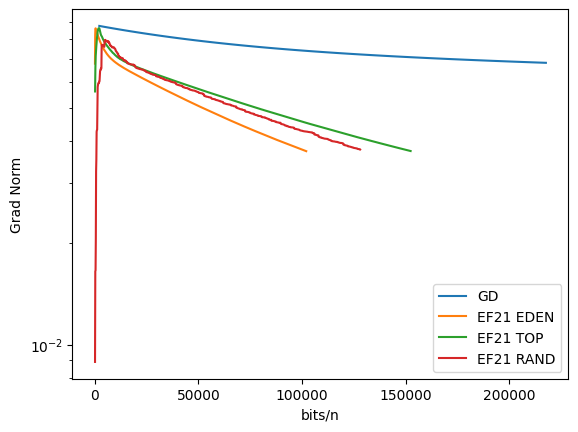

In [9]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS], [metrics.grad_norm for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in EF21_EDEN_METRICS], [metrics.grad_norm for metrics in EF21_EDEN_METRICS], label="EF21 EDEN")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in EF21_TOP_METRICS], [metrics.grad_norm for metrics in EF21_TOP_METRICS], label="EF21 TOP")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in EF21_RAND_METRICS], [metrics.grad_norm for metrics in EF21_RAND_METRICS], label="EF21 RAND")
plt.yscale("log")

plt.xlabel("bits/n")
plt.ylabel("Grad Norm")
plt.legend()